In [1]:
import qutip as qt
import numpy as np
import scqubits as scq
import matplotlib.pyplot as plt
import itertools
import warnings
import os
import time

levels = 6
fluxonium = scq.Fluxonium(EJ=8.9, EC=2.5, EL=0.5, flux=0.48, cutoff=110)
c_ops = None  # will be initialized once below

def init_c_ops():
    gamma_ij = {}
    for j in range(1, levels):
        for i in range(j):
            t1 = fluxonium.t1_capacitive(j, i, Q_cap=1e5, total=False)
            if t1 is not None and t1 > 0:
                rate = 1.0 / t1
                gamma_ij[(i, j)] = rate
                gamma_ij[(j, i)] = rate
    c_ops_local = []
    for (i, j), gamma in gamma_ij.items():
        cop = np.sqrt(gamma) * qt.basis(levels, i) * qt.basis(levels, j).dag()
        c_ops_local.append(cop)
    return c_ops_local

scq.settings.T1_DEFAULT_WARNING=False


if c_ops is None:
    c_ops = init_c_ops()

evals, evecs = fluxonium.eigensys(evals_count=levels)
n_op_energy_basis = qt.Qobj(fluxonium.process_op(fluxonium.n_operator(), energy_esys=(evals, evecs)))
H0 = qt.Qobj(np.diag(evals)) * 2 * np.pi
A = 0.4 * 2 * np.pi
drive_op = n_op_energy_basis
H = [H0, [A * drive_op, 'cos(wd * t)']]



In [2]:
def evolve(omega_d, t_g):
    args = {'wd': omega_d}
    options = qt.Options(nsteps=1000000, store_states=True, atol=1e-10, rtol=1e-9)

    propagator = qt.propagator(H, t_g, args=args, options=options, c_ops=c_ops)
    propagator_kraus = qt.to_kraus(propagator)
    propagator_2x2 = [qt.Qobj(k.full()[:2, :2]) for k in propagator_kraus]
    p_2x2_super = qt.kraus_to_super(propagator_2x2)
    fidelity = qt.average_gate_fidelity(p_2x2_super, qt.sigmax())
    print("completed iteration")
    return fidelity

def wrapped_evolve(args):
    return evolve(*args)


from joblib import Parallel, delayed
from tqdm.notebook import tqdm  # Better in Jupyter


def parallel_map_qutip(task, values, task_args=tuple(), task_kwargs={}, **kwargs):
    """
    ---
    peterg NOTE: This is a modified parallel_map taken from qutip's source
    code. The version I would typically use, can break on some code that uses
    qutip's internal routines. This is likely due to some conflict with the
    openmp code (which the code below "turns off" via an environmental
    variable).  My slight modification is to to allow pathos (assumed imported
    as "mp") module to be used, as it handles pickle'ing various fancy objects
    much better.
    ---


    Parallel execution of a mapping of `values` to the function `task`. This
    is functionally equivalent to::

        result = [task(value, *task_args, **task_kwargs) for value in values]

    Parameters
    ----------
    task : a Python function
        The function that is to be called for each value in ``task_vec``.
    values : array / list
        The list or array of values for which the ``task`` function is to be
        evaluated.
    task_args : list / dictionary
        The optional additional argument to the ``task`` function.
    task_kwargs : list / dictionary
        The optional additional keyword argument to the ``task`` function.
    progress_bar : ProgressBar
        Progress bar class instance for showing progress.

    Returns
    --------
    result : list
        The result list contains the value of
        ``task(value, *task_args, **task_kwargs)`` for
        each value in ``values``.

    """
    os.environ["QUTIP_IN_PARALLEL"] = "TRUE"
    kw = _default_kwargs()
    if "num_cpus" in kwargs:
        kw["num_cpus"] = kwargs["num_cpus"]
    
    kw["num_cpus"] = 7

    nfinished = [0]


    try:
        pool = mp.Pool(processes=kw["num_cpus"])

        async_res = [
            pool.apply_async(
                task, (value,) + task_args, task_kwargs
            )
            for value in values
        ]

        while not all([ar.ready() for ar in async_res]):
            for ar in async_res:
                ar.wait(timeout=0.1)

        pool.terminate()
        pool.join()

    except KeyboardInterrupt as e:
        os.environ["QUTIP_IN_PARALLEL"] = "FALSE"
        pool.terminate()
        pool.join()
        raise e

    os.environ["QUTIP_IN_PARALLEL"] = "FALSE"
    return [ar.get() for ar in async_res]


def varg_opt(data, axis=None, opt_fun=np.nanargmin):
    """
    Return an index of a (possibly) multi-dimensional array of the element that
    optimizes a given function along with the optimal value.
    """
    index = arg_opt(data, axis=axis, opt_fun=opt_fun)
    return index, data[index]

def parallel_map_adapter(f, iterable):
    return parallel_map_qutip(f, list(iterable))


def param_map(f, parameters, map_fun=map, dtype=object):

    dims_list = [len(i) for i in parameters]
    total_dim = np.prod(dims_list)
    parameters_prod = tuple(itertools.product(*parameters))

    data = np.empty(total_dim, dtype=dtype)
    # for i, d in enumerate(map_fun(f, parameters_prod)):
    #     data[i] = d
    for i, d in enumerate(map_fun(lambda args: f(*args), parameters_prod)):
        data[i] = d
    print("complete param map")
    return np.reshape(data, dims_list)


In [3]:
########################################### Running ###########################################

evals, _ = fluxonium.eigensys(evals_count=levels)
omega_d_base = (evals[1] - evals[0]) * 2 * np.pi

print("omega d is", omega_d_base)

dimensions_omega = 8
dimensions_time = 7

omega_d_array = np.linspace(omega_d_base - 0.01, omega_d_base + 0.01, dimensions_omega)

t_g_array = np.linspace(24.2, 24.6, dimensions_time)
# param_pairs = list(itertools.product(omega_d_array, t_g_array))

# print(f"Total simulations to run: {len(param_pairs)}")

warnings.filterwarnings(
    "ignore",
    module="qutip.*"  # Regex pattern to match all warnings from qutip
)
scq.settings.T1_DEFAULT_WARNING=False

try:
    import pathos.multiprocessing as mp
except ImportError:
    print(
        "using std lib version of multiprocessing; consider installing pathos; it's much more robust"
    )
    import multiprocessing as mp

def _default_kwargs():
    return {"num_cpus": os.cpu_count() or 1}

omega d is 3.209910268567999


In [4]:
#single process
# fidelity_results = param_map(evolve, [omega_d_array, t_g_array])

#parallel process
fidelity_results = param_map(evolve, [omega_d_array, t_g_array], map_fun=parallel_map_qutip)

completed iteration
completed iterationcompleted iteration

completed iteration
completed iteration
completed iteration
completed iteration
completed iteration
completed iteration
completed iterationcompleted iteration

completed iteration
completed iteration
completed iteration
completed iteration
completed iteration
completed iteration
completed iteration
complete param map


In [5]:
########################################### Prints ###########################################

print("t g array is ", t_g_array)
print("omega d array is ", omega_d_array)
print("Omega by time dimensions are ", dimensions_omega, " by ", dimensions_time)
print("fidelity results are ", fidelity_results)

t g array is  [24.2  24.28 24.36 24.44 24.52 24.6 ]
omega d array is  [3.19991027 3.20991027 3.21991027]
Omega by time dimensions are  3  by  6
fidelity results are  [[0.8090026837405878 0.8784443929187239 0.9333025872112751
  0.9700122235966391 0.9869076843612766 0.982518911261172]
 [0.8744334379456639 0.9304071762945624 0.9682370654338884
  0.9856297727239385 0.9822345666501437 0.9578053395121162]
 [0.9198209798362207 0.9585391161003706 0.9769250721781177
  0.9740819954641774 0.9509365897540564 0.908446025486826]]


In [6]:
#plot generator

def density(
    z,
    x_array,
    y_array,
    x_label=None,
    y_label=None,
    data_label=None,
    title=None,
    fig_ax=None,
    process_fun=None,
    z_min_max=None,
    norm_fun=None,
    show_values=False,
    **kwargs,
):
    """
    norm_fun should typically be: lambda (z_min, z_max): SymLogNorm(1e-9, 1.0, vmin=z_min, vmax=z_max)
    with: from matplotlib.colors import LogNorm, SymLogNorm
    """
    global global_fig, global_axes
 
    fig, ax = fig_ax or plt.subplots(1, 1, 
            # figsize=(14,12)
            )
    global_fig, global_axes = fig, ax
 
    x, y = np.meshgrid(x_array, y_array)
 
    z = np.ma.array(z)
 
    if process_fun is not None:
        z = process_fun(z)
 
    if z_min_max is not None and not callable(z_min_max):
        z_min = np.nanmin(z) if z_min_max[0] is None else z_min_max[0]
        z_max = np.nanmax(z) if z_min_max[1] is None else z_min_max[1]
    else:
        z_min, z_max = np.nanmin(z), np.nanmax(z)
 
    print(z_min, z_max)
 
    norm = None
    if norm_fun is not None:
        norm = norm_fun(z_min, z_max)
        z_min, z_max = None, None
 
    # extent=[x_array[0], x_array[-1], y_array[0], y_array[-1]]
    # im = ax.imshow(z.T,
    # interpolation=None,
    # cmap="jet",
    # origin='lower',
    # vmin=z_min, vmax=z_max,
    # # extent=extent,
    # aspect='auto',
    # **kwargs
    # )
 
    im = ax.pcolormesh(
        x_array,
        y_array,
        z.T,
        cmap="jet",
        vmin=z_min,
        vmax=z_max,
        norm=norm,
        shading="auto",
        **kwargs,
    )
 
    c1 = fig.colorbar(im, ax=ax)
    c1.ax.set_title(data_label, fontsize=12)
 
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
 
    ax.set_title(title)
 
    return fig, ax

0.8090026837405878 0.9869076843612766


(<Figure size 640x480 with 2 Axes>, <Axes: >)

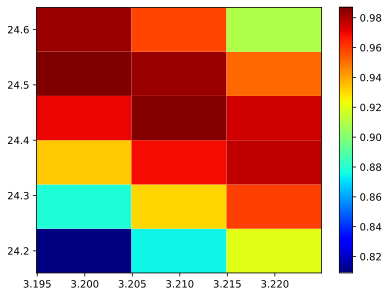

In [7]:
fidelity_results = np.asarray(fidelity_results,dtype = float)

density(fidelity_results, omega_d_array, t_g_array)